<a href="https://colab.research.google.com/github/kamrulkonok/UPC_ML_Project/blob/Konok/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
# merged data file
df = pd.read_csv("./airbnb_data.csv")
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  float64
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  float64
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

## Meaning of variables

- realSum : Price of accommodation for two people for two nights (EUR)
- room_type : type of accommodation ['Private room', 'Entire home/apt', 'Shared room']
- room_shared : variable for shared rooms ['True', 'False']
- room_private : variable for private rooms ['True', 'False']
- person_capacity : maximum number of guests
- host_is_superhost : superhost status ['True', 'False']
- multi : if listing belongs to host with 2-4 offers [0, 1]
- biz : if listing belongs to host with > 4 offers [0, 1]
- cleanliness_rating
- guest_satisfaction_overall : overall rating of listing
- bedrooms : number of bedrooms (0 for studios)
- dist : distance from city centre (in km)
- metro_dist : distance from nearest metro station (in km)
- attr_index : attraction index of listing location
- attr_index_norm : normalized attraction index (0 - 100)
- rest_index : restaurant index of listing location
- rest_index_norm : normalized restaurant index (0 - 100)
- lng : longitude
- lat : latitude
- city
- day_type : weekend or weekday

# Data Preprocessing

## 0. Basic checks

In [4]:
# checking for duplicates
df.duplicated().sum()

0

In [5]:
# check for NaNs
df.isna().sum()

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
day_type                      0
dtype: int64

In [6]:
# to showcase both numerical and categorical variables
df.describe(include='all')

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type
count,51707.000000,51707,51707,51707,51707.000000,51707,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707,51707
unique,NaN,3,2,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,2
top,NaN,Entire home/apt,False,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,london,weekends
freq,NaN,32648,51341,33014,NaN,38475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9993,26207
mean,279.879591,NaN,NaN,NaN,3.161661,NaN,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128,NaN,NaN
std,327.948386,NaN,NaN,NaN,1.298545,NaN,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263,NaN,NaN
min,34.779339,NaN,NaN,NaN,2.000000,NaN,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000,NaN,NaN
25%,148.752174,NaN,NaN,NaN,2.000000,NaN,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510,NaN,NaN
50%,211.343089,NaN,NaN,NaN,3.000000,NaN,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690,NaN,NaN
75%,319.694287,NaN,NaN,NaN,4.000000,NaN,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885,NaN,NaN


In [7]:
# categorical columns (including booleans & binary)
cat_columns = ['room_type', 'room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz', 'city', 'day_type']

In [8]:
def print_unique_values(df, columns):
    # print all unique values in the specified columns of a dataframe.
    for column in columns:
        if column in df.columns:
            unique_values_counts = df[column].value_counts()
            print(f"Unique values in column '{column}' and their counts:")
            for value, count in unique_values_counts.items():
                print(f"{value}: {count}")
            print("\n")

In [9]:
# check if the categorical columns have the correct categories within
print_unique_values(df, cat_columns)

Unique values in column 'room_type' and their counts:
Entire home/apt: 32648
Private room: 18693
Shared room: 366


Unique values in column 'room_shared' and their counts:
False: 51341
True: 366


Unique values in column 'room_private' and their counts:
False: 33014
True: 18693


Unique values in column 'host_is_superhost' and their counts:
False: 38475
True: 13232


Unique values in column 'multi' and their counts:
0: 36642
1: 15065


Unique values in column 'biz' and their counts:
0: 33599
1: 18108


Unique values in column 'city' and their counts:
london: 9993
rome: 9027
paris: 6688
lisbon: 5763
athens: 5280
budapest: 4022
vienna: 3537
barcelona: 2833
berlin: 2484
amsterdam: 2080


Unique values in column 'day_type' and their counts:
weekends: 26207
weekdays: 25500




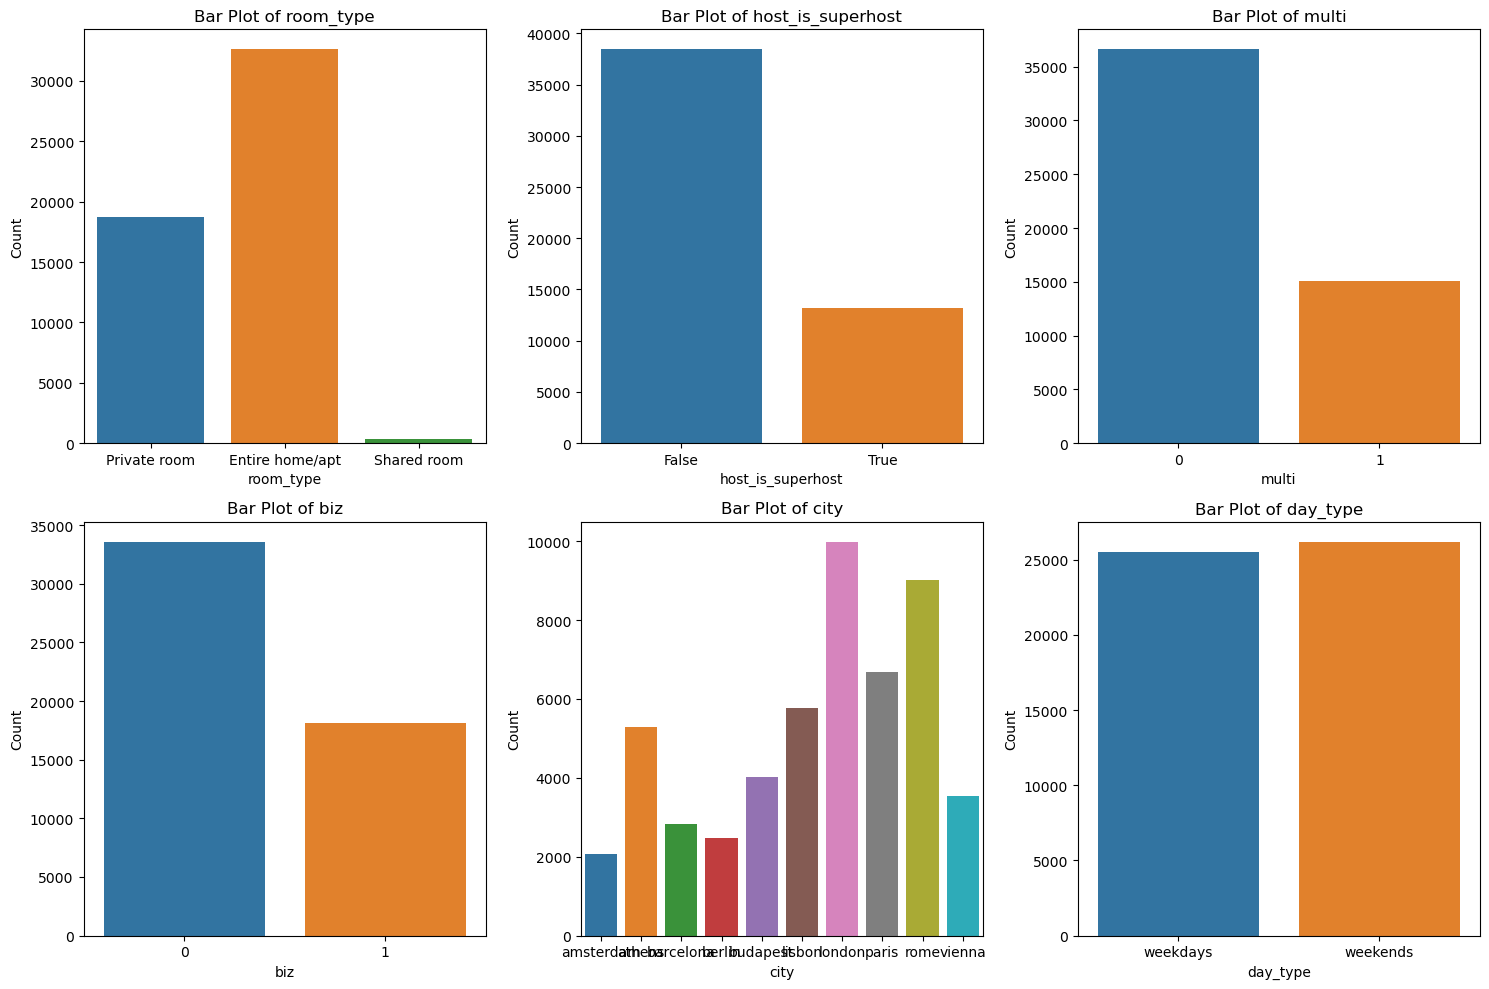

In [10]:
# Check if the data is balanced or not

categorical_columns = ["room_type", "host_is_superhost", "multi", "biz", "city", "day_type"]

plt.figure(figsize=(15, 10))

for i, column in enumerate(categorical_columns, start=1):
    plt.subplot(2, 3, i)
    sns.countplot(x=df[column])
    plt.title(f"Bar Plot of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

# POI 
- I can probably try to remove `room_shared` column? or try to make the data more stratifed through sampling? categorical imbalance in data.
- What is the difference between `room_shared`, `room_type` and `room_private` variables?

In [11]:
# Remove irrelevant columns (attr_index and rest_index as their normalized forms exist, and location coordinates)

cols_to_drop = ['lng', 'lat', 'attr_index', 'rest_index']
df = df.drop(columns=cols_to_drop)

In [12]:
df.describe() # only numerical columns

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,13.423792,22.786177
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,9.807985,17.804096
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,0.926301,0.592757
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,6.380926,8.751480
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,11.468305,17.542238
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,17.415082,32.964603
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,100.000000,100.000000


## 1. Convert Categorical Variables to Encodings

Label Encodings are used when there is an inherent order between the categories i.e. 1, 2, 3 actually mean something in that order. But in our case, all the categories in a column are independent and don't represent any order. Therefore, we go with One Hot Encoding.

Applying one hot encoding to `room_type`, `multi`, `biz`, `city`, `day_type` columns which contains categorical values.

One-hot encoding isn't typically used for binary variables like True and False because it's redundant; the information is already encoded in a single binary feature.

True --> 1
False --> 0 

In [13]:
def one_hot_encode_column(df, column_name):
    # Extract the column to be encoded
    data = df[[column_name]]
    onehot_encoder = OneHotEncoder()
    # Fit and transform the data
    onehot_encoded = onehot_encoder.fit_transform(data)
    # Get the feature names
    feature_names = onehot_encoder.get_feature_names_out([column_name])

    # Create a DataFrame from the one-hot encoded array
    onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=feature_names)

    # Drop the original column from the DataFrame
    df.drop(column_name, axis=1, inplace=True)

    # Concatenate the one-hot encoded DataFrame with the original DataFrame
    df = pd.concat([df, onehot_encoded_df], axis=1)

    return df
    

In [14]:
# I felt that using sklearn one hot encoding would be better, but yours works already
# df = one_hot_encode_column(df, 'room_type')
# df = one_hot_encode_column(df, 'city')
# df = one_hot_encode_column(df, 'day_type')

# note that other binary categorical columns are already in binary forms (0, 1).
# df['room_shared'] = df['room_shared'].astype(int)
# df['room_private'] = df['room_private'].astype(int)
# df['host_is_superhost'] = df['host_is_superhost'].astype(int)

In [15]:
df['room_type'].value_counts()

room_type
Entire home/apt    32648
Private room       18693
Shared room          366
Name: count, dtype: int64

In [16]:
df['city'].value_counts()

city
london       9993
rome         9027
paris        6688
lisbon       5763
athens       5280
budapest     4022
vienna       3537
barcelona    2833
berlin       2484
amsterdam    2080
Name: count, dtype: int64

In [17]:
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,city,day_type
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,4.166708,6.846473,amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,33.421209,58.342928,amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,3.985908,6.646700,amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,26.119108,60.973565,amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,29.272733,56.811677,amsterdam,weekdays


## One Hot Encoding or Dummy Encoding?


When to Use Each
One-Hot Encoding: This is useful when you want to ensure no information is lost, which can be important for certain models, particularly those that do not suffer from multicollinearity issues (e.g., decision trees, neural networks).


Dummy Encoding: This is commonly used in linear models (e.g., linear regression, logistic regression) to avoid multicollinearity, which can cause issues in estimating the model parameters accurately.


https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding/329281#329281

With linear regression, or generalized linear models estimated by maximum likelihood (or least squares) (in R this means using functions lm or glm), you need to leave out one column. Otherwise you will get a message about some columns "left out because of singularities".

But if you estimate such models with regularization, for example ridge, lasso er the elastic net, then you should not leave out any columns. The regularization takes care of the singularities, and more important, the prediction obtained may depend on which columns you leave out. That will not happen when you do not use regularization

In [18]:
df = pd.get_dummies(
    df,
    columns=["room_type", "city", "day_type"],  # I dont think "multi", "biz", should be there.
    drop_first=True
)

# Convert boolean columns to integers (1 or 0)
for col in df.select_dtypes(include=[bool]).columns:
    df[col] = df[col].astype(int)


In [19]:
len(df.columns)

26

In [20]:
df.head()

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,room_type_Private room,room_type_Shared room,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekends
0,194.033698,0,1,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,4.166708,6.846473,1,0,0,0,0,0,0,0,0,0,0,0
1,344.245776,0,1,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,33.421209,58.342928,1,0,0,0,0,0,0,0,0,0,0,0
2,264.101422,0,1,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,3.985908,6.646700,1,0,0,0,0,0,0,0,0,0,0,0
3,433.529398,0,1,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,26.119108,60.973565,1,0,0,0,0,0,0,0,0,0,0,0
4,485.552926,0,1,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,29.272733,56.811677,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df['day_type_weekends'].value_counts()  # no need to make two columns for it.

day_type_weekends
1    26207
0    25500
Name: count, dtype: int64

## 2. Finding Outliers

Since Machine learning models can be affected by high values, therefore it is important to take care / acknowledge the presence of outliers, if any.

### IQR

One easy criteria to decide which values are outliers is to use the distance between quartiles. Specifically, you define the outliers as:
* The values smaller than Q1 - 1.5*IQR
* The values bigger than Q3 + 1.5*IQR

This is the criteria used in the boxplots to marc the outliers.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/1024px-Boxplot_vs_PDF.svg.png" alt="nice_image_from_wikipedia" width="450"/>

In [22]:
df.describe()

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,room_type_Private room,room_type_Shared room,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekends
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,0.007078,0.361518,3.161661,0.255903,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,13.423792,22.786177,0.361518,0.007078,0.102114,0.054789,0.048040,0.077784,0.111455,0.193262,0.129344,0.174580,0.068405,0.506837
std,327.948386,0.083835,0.480445,1.298545,0.436372,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,9.807985,17.804096,0.480445,0.083835,0.302801,0.227571,0.213853,0.267835,0.314698,0.394861,0.335584,0.379611,0.252441,0.499958
min,34.779339,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,0.926301,0.592757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,148.752174,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,6.380926,8.751480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,211.343089,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,11.468305,17.542238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,319.694287,0.000000,1.000000,4.000000,1.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,17.415082,32.964603,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,18545.450285,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


realSum, dist, metro_dist, attr_index_norm & rest_index_norm all have outliers.

In [23]:
# Function to find outliers using IQR for each column
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [24]:
outliers = find_outliers_iqr(df, 'realSum')
outliers.sort_values(by='realSum', ascending=False)['realSum']

3590     18545.450285
34803    16445.614689
24348    15499.894165
48380    13664.305916
50787    13656.358834
             ...     
45338      576.298132
40830      576.298132
8766       576.256197
630        576.242589
16312      576.209052
Name: realSum, Length: 3662, dtype: float64

In [25]:
df.describe()

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,room_type_Private room,room_type_Shared room,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekends
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,0.007078,0.361518,3.161661,0.255903,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,13.423792,22.786177,0.361518,0.007078,0.102114,0.054789,0.048040,0.077784,0.111455,0.193262,0.129344,0.174580,0.068405,0.506837
std,327.948386,0.083835,0.480445,1.298545,0.436372,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,9.807985,17.804096,0.480445,0.083835,0.302801,0.227571,0.213853,0.267835,0.314698,0.394861,0.335584,0.379611,0.252441,0.499958
min,34.779339,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,0.926301,0.592757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,148.752174,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,6.380926,8.751480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,211.343089,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,11.468305,17.542238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,319.694287,0.000000,1.000000,4.000000,1.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,17.415082,32.964603,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,18545.450285,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
outliers.query('realSum > 1200')

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,room_type_Private room,room_type_Shared room,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekends
7,2771.307384,0,0,4.0,1,0,0,10.0,100.0,3,1.686807,1.458404,11.056528,18.975219,0,0,0,0,0,0,0,0,0,0,0,0
35,1609.917278,0,0,6.0,0,1,0,10.0,96.0,3,2.988589,1.750003,11.011222,16.847448,0,0,0,0,0,0,0,0,0,0,0,0
92,1557.190730,0,0,4.0,1,0,0,9.0,98.0,2,0.750395,0.808683,44.173966,42.063930,0,0,0,0,0,0,0,0,0,0,0,0
99,3004.944579,0,0,4.0,0,0,0,9.0,95.0,4,1.615295,1.402539,11.472769,19.762890,0,0,0,0,0,0,0,0,0,0,0,0
102,1376.514424,0,0,4.0,1,0,1,10.0,93.0,2,1.930702,1.585825,9.799591,17.310023,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47009,2311.738714,0,1,2.0,0,0,0,10.0,100.0,1,1.731672,1.054644,6.828503,17.853945,1,0,0,0,0,0,0,0,0,1,0,1
47039,1907.044163,0,0,5.0,0,1,0,6.0,60.0,3,2.978378,1.148510,15.739358,34.808324,0,0,0,0,0,0,0,0,0,1,0,1
48215,12942.991375,0,0,4.0,0,0,1,7.0,93.0,1,1.497979,0.396893,8.864325,4.685995,0,0,0,0,0,0,0,0,0,0,1,0
48380,13664.305916,0,1,2.0,0,0,0,9.0,87.0,1,2.239501,0.414395,9.191812,4.818080,1,0,0,0,0,0,0,0,0,0,1,0


Should we remove these?

In [27]:
# add code to remove outliers

## 3. Transformations for Distribution

We have found from our EDA that `realSum` column has outliers due to its skewness, # What does this mean Konok?



Therefore apply log transformation to reduce it and creating a new column `price` to store the transformed values

## Determine skewness

Interpretation of Skewness Values


Skewness ≈ 0: The data is fairly symmetrical.

Skewness > 0: The data is positively skewed (right-skewed), with a longer tail on the right side of the distribution.

Skewness < 0: The data is negatively skewed (left-skewed), with a longer tail on the left side of the distribution.

In [28]:
df.skew()

realSum                       21.419957
room_shared                   11.759724
room_private                   0.576497
person_capacity                0.760003
host_is_superhost              1.118798
multi                          0.918395
biz                            0.628049
cleanliness_rating            -2.850286
guest_satisfaction_overall    -3.174908
bedrooms                       1.367776
dist                           1.731195
metro_dist                     4.060445
attr_index_norm                2.193167
rest_index_norm                1.097455
room_type_Private room         0.576497
room_type_Shared room         11.759724
city_athens                    2.628140
city_barcelona                 3.912867
city_berlin                    4.226999
city_budapest                  3.152929
city_lisbon                    2.469418
city_london                    1.553712
city_paris                     2.209107
city_rome                      1.714559
city_vienna                    3.419502


Skewness is present in realSum, which is the y variable. If your target variable (y) is positively skewed, transforming it can often be beneficial. Many machine learning models, particularly linear models, assume that the target variable is normally distributed. Transforming a positively skewed y can help in meeting this assumption, leading to better model performance and more reliable predictions. It can also help in reducing the impact of outliers.

Skewness is also present in room_shared, because there are only 366 values supporting it. Same for room_type_shared.

Log Transformation : This is effective for data that are strictly positive.

In [29]:
df['price'] = np.log(df['realSum'])
df = df.drop(columns=['realSum'])
df.head()

,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,room_type_Private room,room_type_Shared room,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekends,price
0,0,1,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,4.166708,6.846473,1,0,0,0,0,0,0,0,0,0,0,0,5.268032
1,0,1,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,33.421209,58.342928,1,0,0,0,0,0,0,0,0,0,0,0,5.841356
2,0,1,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,3.985908,6.646700,1,0,0,0,0,0,0,0,0,0,0,0,5.576333
3,0,1,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,26.119108,60.973565,1,0,0,0,0,0,0,0,0,0,0,0,6.071960
4,0,1,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,29.272733,56.811677,1,0,0,0,0,0,0,0,0,0,0,0,6.185288


## 4. Normalization

If you try to train a model with variables of ranges too far away it will be a disaster most of the times. Becasue the model might only "see" the bigger variable.

To avoid this issue you usualy normalize or standardize your data. This way you force all your variables to have the same range.
There are models that are very sensitive to this and might even fail to converge if you don't normalize your data.

The most common transformations for normalizing the data are:
* Standarization: $\frac{X - \mu}{\sigma}$ will trasnform your data so it has mean 0 and std 1.
* Min-max scaling: $\frac{X - X_{min}}{X_{max} - X_{min}}$ will send your data to the range [0,1]
* Boxcox transformation: $\frac{X^\lambda - 1}{ \lambda}$ if $\lambda \neq 0$ or $ln(X)$ if $\lambda = 0$ transforms the data to try to fit a normal distribution.

In [30]:
df.head()

,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,room_type_Private room,room_type_Shared room,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekends,price
0,0,1,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,4.166708,6.846473,1,0,0,0,0,0,0,0,0,0,0,0,5.268032
1,0,1,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,33.421209,58.342928,1,0,0,0,0,0,0,0,0,0,0,0,5.841356
2,0,1,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,3.985908,6.646700,1,0,0,0,0,0,0,0,0,0,0,0,5.576333
3,0,1,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,26.119108,60.973565,1,0,0,0,0,0,0,0,0,0,0,0,6.071960
4,0,1,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,29.272733,56.811677,1,0,0,0,0,0,0,0,0,0,0,0,6.185288


Applying Min-Max Scaling to the `dist` (distance from city center) and `metro_dist` (distance from nearest metro station) columns to normalize these features into a consistent range of 0 to 1.

In [31]:
scaler = MinMaxScaler()

columns_to_scale = ['dist', 'metro_dist']

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print(df[columns_to_scale].head())

       dist  metro_dist
0  0.198180    0.177775
1  0.018732    0.016614
2  0.226885    0.255711
3  0.014635    0.030661
4  0.020962    0.022170


Standardization is applied to the `cleanliness_rating` and `guest_satisfaction_overall` columns to ensure that these variables have zero mean and unit variance.

In [32]:
scaler = StandardScaler()

columns_to_standardize = ['cleanliness_rating', 'guest_satisfaction_overall']

df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

print(df[columns_to_standardize].head())

   cleanliness_rating  guest_satisfaction_overall
0            0.638184                    0.041559
1           -1.456366                   -0.852751
2           -0.409091                   -0.629173
3           -0.409091                   -0.293807
4            0.638184                    0.600503


In [33]:
df.columns

Index(['room_shared', 'room_private', 'person_capacity', 'host_is_superhost',
       'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'attr_index_norm', 'rest_index_norm',
       'room_type_Private room', 'room_type_Shared room', 'city_athens',
       'city_barcelona', 'city_berlin', 'city_budapest', 'city_lisbon',
       'city_london', 'city_paris', 'city_rome', 'city_vienna',
       'day_type_weekends', 'price'],
      dtype='object')

In [34]:
vif_data = pd.DataFrame()
vif_data['feature'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f"{x:.2f}")

print(vif_data)

C:\apps\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                       feature    VIF
0                  room_shared    inf
1                 room_private    inf
2              person_capacity  14.86
3            host_is_superhost   1.54
4                        multi   1.94
5                          biz   2.39
6           cleanliness_rating   2.09
7   guest_satisfaction_overall   2.18
8                     bedrooms   7.10
9                         dist   9.21
10                  metro_dist   2.72
11             attr_index_norm   9.25
12             rest_index_norm   9.17
13      room_type_Private room    inf
14       room_type_Shared room    inf
15                 city_athens   2.74
16              city_barcelona   2.19
17                 city_berlin   2.32
18               city_budapest   2.39
19                 city_lisbon   3.29
20                 city_london   7.09
21                  city_paris   4.38
22                   city_rome   4.23
23                 city_vienna   2.42
24           day_type_weekends   2.05
25          

Why are some values coming as infinite?

In [24]:
df.head()

,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,room_type_Private room,room_type_Shared room,multi_1,biz_1,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekends,price
0,0,1,2.0,0,0.638184,0.041559,1,0.198180,0.177775,4.166708,6.846473,1,0,1,0,0,0,0,0,0,0,0,0,0,0,5.268032
1,0,1,4.0,0,-1.456366,-0.852751,1,0.018732,0.016614,33.421209,58.342928,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5.841356
2,0,1,2.0,0,-0.409091,-0.629173,1,0.226885,0.255711,3.985908,6.646700,1,0,0,1,0,0,0,0,0,0,0,0,0,0,5.576333
3,0,1,4.0,0,-0.409091,-0.293807,2,0.014635,0.030661,26.119108,60.973565,1,0,0,1,0,0,0,0,0,0,0,0,0,0,6.071960
4,0,1,2.0,1,0.638184,0.600503,1,0.020962,0.022170,29.272733,56.811677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6.185288


In [35]:
# save to csv

df.to_csv('preprocessed_airbnb_data.csv', index=False)

# Feature Engineering - I AM NOT RUNNING THIS RIGHT NOW.

As the `bedrooms` and `person_capacity` has higher collinearity, therefore, combining them into one feature and naming it `space_index`, same logic has been applied to the `metro_to_city_dist_ratio`. Applying binning to the `dist` to make categorical value based on close, moderate and far distance assumptions

In [20]:
# # Plot heatmap
# plt.figure(figsize=(12, 12))
# sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".1f")
# plt.title('Heatmap of DataFrame')
# plt.show()

In [168]:
df['space_index'] = df['bedrooms'] * df['person_capacity']

df['metro_to_city_dist_ratio'] = df['metro_dist'] / df['dist']

bins = [0, 3, 10, float('inf')]
labels = [1, 2, 3]  # 1 for close, 2 for moderate, 3 for far
df['dist_category'] = pd.cut(df['dist'], bins=bins, labels=labels)

df['dist_category'] = pd.to_numeric(df['dist_category'])

In [169]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

vif_data = pd.DataFrame()
vif_data['feature'] = df.columns
vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f"{x:.2f}")

print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                       feature         VIF
0                   Unnamed: 0        1.48
1                      realSum        2.09
2                  room_shared         inf
3                 room_private         inf
4              person_capacity        6.40
5            host_is_superhost        1.15
6           cleanliness_rating        2.11
7   guest_satisfaction_overall        2.18
8                     bedrooms        9.75
9                         dist        3.76
10                  metro_dist        1.84
11                  attr_index        9.71
12             attr_index_norm        8.76
13                  rest_index        8.52
14             rest_index_norm        6.00
15                         lng    62872.00
16                         lat    63369.25
17      room_type_Private room         inf
18       room_type_Shared room         inf
19                     multi_1        1.38
20                       biz_1        1.58
21                 city_athens    70726.25
22         

# Removing reduntant features

In [170]:
cols_to_drop = ['room_shared', 'room_private', 'bedrooms', 'person_capacity']

df_reduced = df.drop(columns=cols_to_drop)
df_reduced.columns

Index(['Unnamed: 0', 'host_is_superhost', 'cleanliness_rating',
       'guest_satisfaction_overall', 'attr_index_norm', 'rest_index_norm',
       'room_type_Private room', 'room_type_Shared room', 'multi_1', 'biz_1',
       'city_athens', 'city_barcelona', 'city_berlin', 'city_budapest',
       'city_lisbon', 'city_london', 'city_paris', 'city_rome', 'city_vienna',
       'day_type_weekends', 'price', 'space_index', 'metro_to_city_dist_ratio',
       'dist_category'],
      dtype='object')

The dist_category still contains higher multicollinearity 😞

In [171]:
df_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reduced.dropna(inplace=True)

vif_data = pd.DataFrame()
vif_data['feature'] = df_reduced.columns
vif_data['VIF'] = [variance_inflation_factor(df_reduced.values, i) for i in range(df_reduced.shape[1])]
vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f"{x:.2f}")

print(vif_data)

                       feature     VIF
0                   Unnamed: 0    1.46
1            host_is_superhost    1.15
2           cleanliness_rating    2.10
3   guest_satisfaction_overall    2.18
4              attr_index_norm    2.72
5              rest_index_norm    3.28
6       room_type_Private room    1.80
7        room_type_Shared room    1.06
8                      multi_1    1.37
9                        biz_1    1.54
10                 city_athens    5.03
11              city_barcelona    2.48
12                 city_berlin    2.34
13               city_budapest    3.94
14                 city_lisbon    4.39
15                 city_london    6.55
16                  city_paris    4.39
17                   city_rome    6.21
18                 city_vienna    3.14
19           day_type_weekends    1.01
20                       price    2.90
21                 space_index    1.42
22    metro_to_city_dist_ratio    1.00
23               dist_category  315.15
